In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.ensemble import (
    RandomForestClassifier,
)
from yellowbrick.model_selection import (
    ValidationCurve,
)

url = (
    "http://biostat.mc.vanderbilt.edu/"
    "wiki/pub/Main/DataSets/titanic3.xls"
)
df = pd.read_excel(url)
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)


X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [38]:
ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    StandardScaler,
)
pca = PCA(random_state=42)
X_pca = pca.fit_transform(
    StandardScaler().fit_transform(X)
)
pca.explained_variance_ratio_
pca.components_[0]

array([-0.63274156,  0.39602149,  0.00653646,  0.11500362,  0.5815031 ,
       -0.19764926, -0.20422289, -0.10304598])

[(0, 1),
 Text(0,0.5,'Percent of Explained variance'),
 Text(0.5,0,'Component'),
 Text(0.5,1,'Scree Plot')]

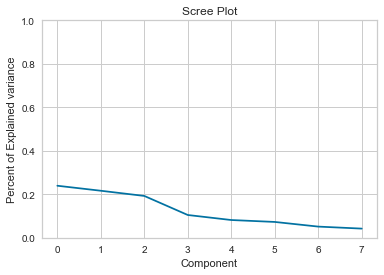

In [40]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(pca.explained_variance_ratio_)
ax.set(
    xlabel="Component",
    ylabel="Percent of Explained variance",
    title="Scree Plot",
    ylim=(0, 1),
)
# fig.savefig(
#     "images/mlpr_1701.png",
#     dpi=300,
#     bbox_inches="tight",
# )

[(0, 1),
 Text(0,0.5,'Percent of Explained variance'),
 Text(0.5,0,'Component'),
 Text(0.5,1,'Cumulative Variance')]

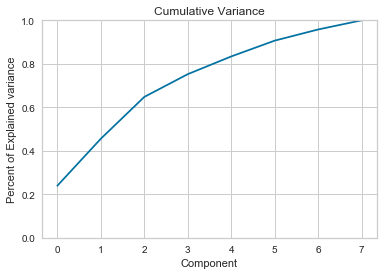

In [41]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(
    np.cumsum(pca.explained_variance_ratio_)
)
ax.set(
    xlabel="Component",
    ylabel="Percent of Explained variance",
    title="Cumulative Variance",
    ylim=(0, 1),
)
#fig.savefig("images/mlpr_1702.png", dpi=300)

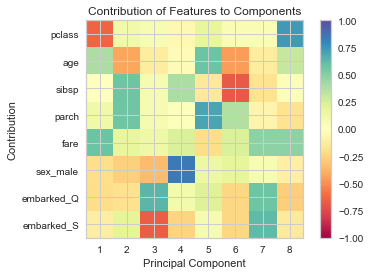

In [42]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.imshow(
    pca.components_.T,
    cmap="Spectral",
    vmin=-1,
    vmax=1,
)
plt.yticks(range(len(X.columns)), X.columns)
plt.xticks(range(8), range(1, 9))
plt.xlabel("Principal Component")
plt.ylabel("Contribution")
plt.title(
    "Contribution of Features to Components"
)
plt.colorbar()
#fig.savefig("images/mlpr_1703.png", dpi=300)

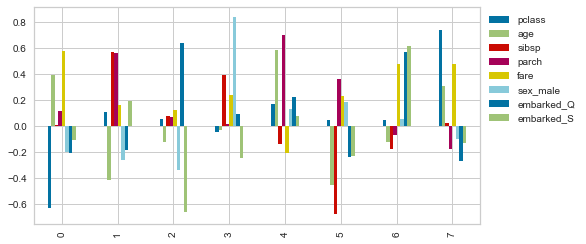

In [43]:
fig, ax = plt.subplots(figsize=(8, 4))
pd.DataFrame(
    pca.components_, columns=X.columns
).plot(kind="bar", ax=ax).legend(
    bbox_to_anchor=(1, 1)
)
#fig.savefig("images/mlpr_1704.png", dpi=300)

In [44]:
comps = pd.DataFrame(
    pca.components_, columns=X.columns
)
min_val = 0.5
num_components = 2
pca_cols = set()
for i in range(num_components):
    parts = comps.iloc[i][
        comps.iloc[i].abs() > min_val
    ]
    pca_cols.update(set(parts.index))
pca_cols

{'fare', 'parch', 'pclass', 'sibsp'}

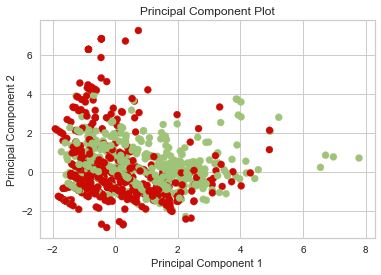

In [45]:
from yellowbrick.features.pca import (
    PCADecomposition,
)
fig, ax = plt.subplots(figsize=(6, 4))
colors = ["rg"[j] for j in y]
pca_viz = PCADecomposition(color=colors)
pca_viz.fit_transform(X, y)
pca_viz.poof()
#fig.savefig("images/mlpr_1705.png", dpi=300)

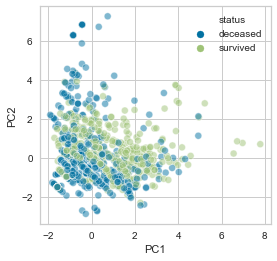

In [46]:
fig, ax = plt.subplots(figsize=(6, 4))
pca_df = pd.DataFrame(
    X_pca,
    columns=[
        f"PC{i+1}"
        for i in range(X_pca.shape[1])
    ],
)
pca_df["status"] = [
    ("deceased", "survived")[i] for i in y
]
evr = pca.explained_variance_ratio_
ax.set_aspect(evr[1] / evr[0])
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="status",
    data=pca_df,
    alpha=0.5,
    ax=ax,
)
# fig.savefig(
#     "images/mlpr_1706.png",
#     dpi=300,
#     bbox_inches="tight",
# )

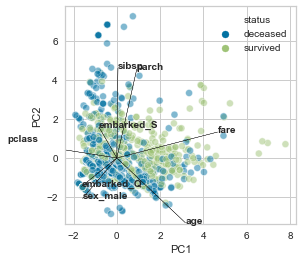

In [47]:
fig, ax = plt.subplots(figsize=(6, 4))
pca_df = pd.DataFrame(
    X_pca,
    columns=[
        f"PC{i+1}"
        for i in range(X_pca.shape[1])
    ],
)
pca_df["status"] = [
    ("deceased", "survived")[i] for i in y
]
evr = pca.explained_variance_ratio_
x_idx = 0  # x_pc
y_idx = 1  # y_pc
ax.set_aspect(evr[y_idx] / evr[x_idx])
x_col = pca_df.columns[x_idx]
y_col = pca_df.columns[y_idx]
sns.scatterplot(
    x=x_col,
    y=y_col,
    hue="status",
    data=pca_df,
    alpha=0.5,
    ax=ax,
)
scale = 8
comps = pd.DataFrame(
    pca.components_, columns=X.columns
)
for idx, s in comps.T.iterrows():
    plt.arrow(
        0,
        0,
        s[x_idx] * scale,
        s[y_idx] * scale,
        color="k",
    )
    plt.text(
        s[x_idx] * scale,
        s[y_idx] * scale,
        idx,
        weight="bold",
    )
# fig.savefig(
#     "images/mlpr_1707.png",
#     dpi=300,
#     bbox_inches="tight",
# )

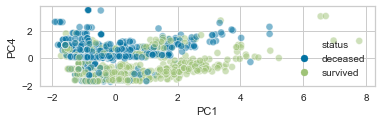

In [48]:
fig, ax = plt.subplots(figsize=(6, 4))
pca_df = pd.DataFrame(
    X_pca,
    columns=[
        f"PC{i+1}"
        for i in range(X_pca.shape[1])
    ],
)
pca_df["status"] = [
    ("deceased", "survived")[i] for i in y
]
evr = pca.explained_variance_ratio_
ax.set_aspect(evr[3] / evr[0])
sns.scatterplot(
    x="PC1",
    y="PC4",
    hue="status",
    data=pca_df,
    alpha=0.5,
    ax=ax,
)
# fig.savefig(
#     "images/mlpr_1708.png",
#     dpi=300,
#     bbox_inches="tight",
# )

In [49]:
from bokeh.io import output_notebook
from bokeh import models, palettes, transform
from bokeh.plotting import figure, show
def bokeh_scatter(
    x,
    y,
    data,
    hue=None,
    label_cols=None,
    size=None,
    legend=None,
    alpha=0.5,
):
    """
    x - x column name to plot
    y - y column name to plot
    data - pandas DataFrame
    hue - column name to color by (numeric)
    legend - column name to label by
    label_cols - columns to use in tooltip
                 (None all in DataFrame)
    size - size of points in screen space unigs
    alpha - transparency
    """
    output_notebook()
    circle_kwargs = {}
    if legend:
        circle_kwargs["legend"] = legend
    if size:
        circle_kwargs["size"] = size
    if hue:
        color_seq = data[hue]
        mapper = models.LinearColorMapper(
            palette=palettes.viridis(256),
            low=min(color_seq),
            high=max(color_seq),
        )
        circle_kwargs[
            "fill_color"
        ] = transform.transform(hue, mapper)
    ds = models.ColumnDataSource(data)
    if label_cols is None:
        label_cols = data.columns
    tool_tips = sorted(
        [
            (x, "@{}".format(x))
            for x in label_cols
        ],
        key=lambda tup: tup[0],
    )
    hover = models.HoverTool(
        tooltips=tool_tips
    )
    fig = figure(
        tools=[
            hover,
            "pan",
            "zoom_in",
            "zoom_out",
            "reset",
        ],
        toolbar_location="below",
    )
    fig.circle(
        x,
        y,
        source=ds,
        alpha=alpha,
        **circle_kwargs
    )
    show(fig)
    return fig
res = bokeh_scatter(
    "PC1",
    "PC2",
    data=pca_df.assign(
        surv=y.reset_index(drop=True)
    ),
    hue="surv",
    size=10,
    legend="surv",
)

Loading BokehJS ...

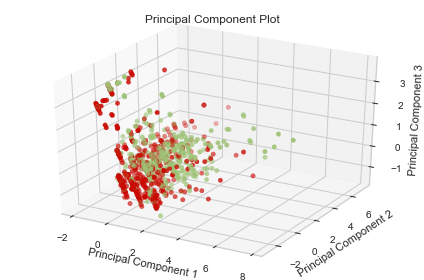

In [50]:
from yellowbrick.features.pca import (
    PCADecomposition,
)
colors = ["rg"[j] for j in y]
pca3_viz = PCADecomposition(
    proj_dim=3, color=colors
)
pca3_viz.fit_transform(X, y)
pca3_viz.finalize()
fig = plt.gcf()
plt.tight_layout()
# fig.savefig(
#     "images/mlpr_1710.png",
#     dpi=300,
#     bbox_inches="tight",
# )

In [51]:
import scprep
scprep.plot.rotate_scatter3d(
    X_pca[:, :3],
    c=y,
    cmap="Spectral",
    figsize=(8, 6),
    label_prefix="Principal Component",
)

ImportError: scprep requires matplotlib>=3 (installed: 2.2.4). Please upgrade it with e.g. `pip install --user --upgrade matplotlib

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    xs=X_pca[:, 0],
    ys=X_pca[:, 1],
    zs=X_pca[:, 2],
    c=y,
    cmap="viridis",
)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

In [ ]:
import umap
u = umap.UMAP(random_state=42)
X_umap = u.fit_transform(
    StandardScaler().fit_transform(X)
)
X_umap.shape

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
pd.DataFrame(X_umap).plot(
    kind="scatter",
    x=0,
    y=1,
    ax=ax,
    c=y,
    alpha=0.2,
    cmap="Spectral",
)
# fig.savefig("images/mlpr_1713.png", dpi=300)

In [ ]:
X_std = StandardScaler().fit_transform(X)
fig, axes = plt.subplots(2, 2, figsize=(6, 4))
axes = axes.reshape(4)
for i, n in enumerate([2, 5, 10, 50]):
    ax = axes[i]
    u = umap.UMAP(
        random_state=42, n_neighbors=n
    )
    X_umap = u.fit_transform(X_std)
    pd.DataFrame(X_umap).plot(
        kind="scatter",
        x=0,
        y=1,
        ax=ax,
        c=y,
        cmap="Spectral",
        alpha=0.5,
    )
    ax.set_title(f"nn={n}")
plt.tight_layout()
#fig.savefig("images/mlpr_1714.png", dpi=300)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(6, 4))
axes = axes.reshape(4)
for i, n in enumerate([0, 0.33, 0.66, 0.99]):
    ax = axes[i]
    u = umap.UMAP(random_state=42, min_dist=n)
    X_umap = u.fit_transform(X_std)
    pd.DataFrame(X_umap).plot(
        kind="scatter",
        x=0,
        y=1,
        ax=ax,
        c=y,
        cmap="Spectral",
        alpha=0.5,
    )
    ax.set_title(f"min_dist={n}")
plt.tight_layout()
#fig.savefig("images/mlpr_1715.png", dpi=300)

In [ ]:
from sklearn.manifold import TSNE
X_std = StandardScaler().fit_transform(X)
ts = TSNE()
X_tsne = ts.fit_transform(X_std)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
colors = ["rg"[j] for j in y]
scat = ax.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=colors,
    alpha=0.5,
)
ax.set_xlabel("Embedding 1")
ax.set_ylabel("Embedding 2")
#fig.savefig("images/mlpr_1716.png", dpi=300)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(6, 4))
axes = axes.reshape(4)
for i, n in enumerate((2, 30, 50, 100)):
    ax = axes[i]
    t = TSNE(random_state=42, perplexity=n)
    X_tsne = t.fit_transform(X)
    pd.DataFrame(X_tsne).plot(
        kind="scatter",
        x=0,
        y=1,
        ax=ax,
        c=y,
        cmap="Spectral",
        alpha=0.5,
    )
    ax.set_title(f"perplexity={n}")
plt.tight_layout()
#fig.savefig("images/mlpr_1717.png", dpi=300)

In [ ]:
import phate
p = phate.PHATE(random_state=42)
X_phate = p.fit_transform(X)
X_phate.shape

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
phate.plot.scatter2d(p, c=y, ax=ax, alpha=0.5)
#fig.savefig("images/mlpr_1718.png", dpi=300)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(6, 4))
axes = axes.reshape(4)
p = phate.PHATE(random_state=42, n_jobs=-1)
for i, n in enumerate((2, 5, 20, 100)):
    ax = axes[i]
    p.set_params(knn=n)
    X_phate = p.fit_transform(X)
    pd.DataFrame(X_phate).plot(
        kind="scatter",
        x=0,
        y=1,
        ax=ax,
        c=y,
        cmap="Spectral",
        alpha=0.5,
    )
    ax.set_title(f"knn={n}")
plt.tight_layout()
#fig.savefig("images/mlpr_1719.png", dpi=300)